# Style Transfer

## 0. Imports

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])

## 1. Loss Function

In [4]:
class ContentLoss(nn.Module):
    def __init__(self, target_feature):
        super(ContentLoss, self).__init__()
        self.target = target_feature.detach()

    def forward(self, input_feature):
        self.loss = torch.mean((input_feature - self.target)**2)
        return input_feature

In [5]:
def gram_matrix(feature_map):
    a, b, c, d = feature_map.size()
    features = feature_map.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input_feature):
        gram = gram_matrix(input_feature)
        self.loss = torch.mean((gram - self.target)**2)
        return input_feature

## 2. Gradient Descent

### 2.1 Setup (Image, Model, Loss)

In [13]:
def load_image(image_path, transform=None):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if transform:
        image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

class Normalization(nn.Module):
    def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]), std=torch.tensor([0.229, 0.224, 0.225])):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

style_img = load_image("../data/q3/styles/zebra.jpg", transform=transform)
content_img = load_image("../data/q3/content/cat-sleeping.jpg", transform=transform)

In [46]:
def get_style_model_and_losses(cnn, style_img, content_img, content_layers=['conv_4'], style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):

    i = 0
    content_losses = []
    style_losses = []
    model = nn.Sequential(Normalization())

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

def plot_style_transfer(style_img, content_img, output_img, title, save_path=None):

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(title)

    axes[0].imshow(style_img.cpu().squeeze().permute(1, 2, 0).numpy())
    axes[0].set_title("Style Image")
    axes[0].axis('off')

    axes[1].imshow(content_img.cpu().squeeze().permute(1, 2, 0).numpy())
    axes[1].set_title("Content Image")
    axes[1].axis('off')

    axes[2].imshow(output_img.cpu().squeeze().permute(1, 2, 0).numpy())
    axes[2].set_title("Output Image")
    axes[2].axis('off')

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

### 2.2 Style Transfer using L-BFGS

Step 50: Style Loss=7.834276, Content Loss=6.007426
Step 100: Style Loss=3.714191, Content Loss=4.301779
Step 150: Style Loss=2.356586, Content Loss=3.907960
Step 200: Style Loss=1.463791, Content Loss=3.797254
Step 250: Style Loss=0.999331, Content Loss=3.698792
Step 300: Style Loss=0.748020, Content Loss=3.580126


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


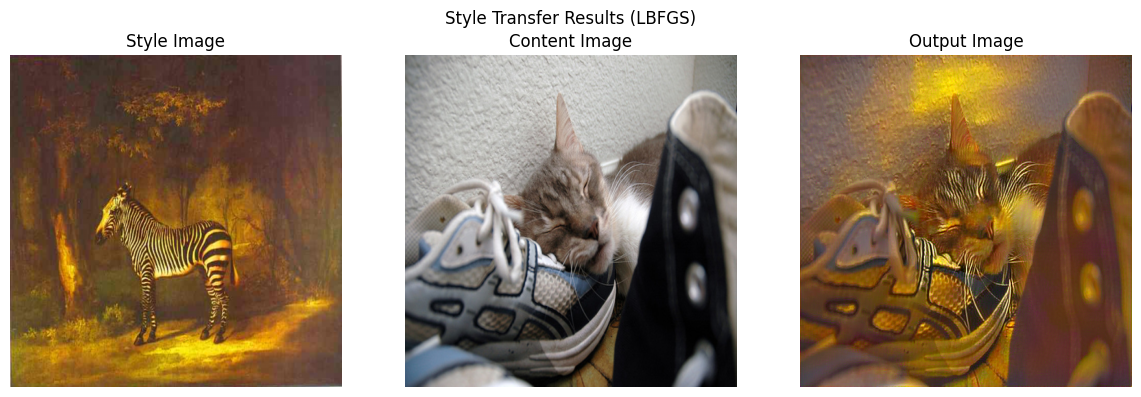

In [28]:
def style_transfer_lbfgs(cnn, style_img, content_img, output_img, num_steps=300, lr=1, style_weight=100000, content_weight=1, log=True):

    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)

    output_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = optim.LBFGS([output_img], lr=lr)

    step = [0]
    while step[0] <= num_steps:

        def closure():
            with torch.no_grad():
                output_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(output_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            step[0] += 1
            if log and step[0] % 50 == 0:
                print(f'Step {step[0]}: Style Loss={style_score.item():4f}, Content Loss={content_score.item():4f}')

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        output_img.clamp_(0, 1)

    return output_img.detach()

cnn = models.vgg19(weights='DEFAULT').features.eval()
output_img = style_transfer_lbfgs(cnn, style_img, content_img, content_img.clone())
plot_style_transfer(style_img, content_img, output_img, "Style Transfer Results (LBFGS)")

### 2.3 Style Transfer using Adam

Step 50: Style Loss=26.160236, Content Loss=5.196325
Step 100: Style Loss=14.239165, Content Loss=4.797906
Step 150: Style Loss=9.441480, Content Loss=4.511909
Step 200: Style Loss=6.865696, Content Loss=4.311793
Step 250: Style Loss=5.392283, Content Loss=4.163329
Step 300: Style Loss=4.499324, Content Loss=4.047002
Step 350: Style Loss=3.900970, Content Loss=3.955617
Step 400: Style Loss=3.463401, Content Loss=3.883735
Step 450: Style Loss=3.122995, Content Loss=3.826041
Step 500: Style Loss=2.847391, Content Loss=3.778301
Step 550: Style Loss=2.618201, Content Loss=3.738423
Step 600: Style Loss=2.424102, Content Loss=3.704231
Step 650: Style Loss=2.256899, Content Loss=3.673926
Step 700: Style Loss=2.110866, Content Loss=3.646831
Step 750: Style Loss=1.982354, Content Loss=3.622227
Step 800: Style Loss=1.868418, Content Loss=3.600126
Step 850: Style Loss=1.768656, Content Loss=3.579809
Step 900: Style Loss=1.681343, Content Loss=3.561855
Step 950: Style Loss=1.607043, Content Loss=3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


Step 1000: Style Loss=1.539325, Content Loss=3.530883


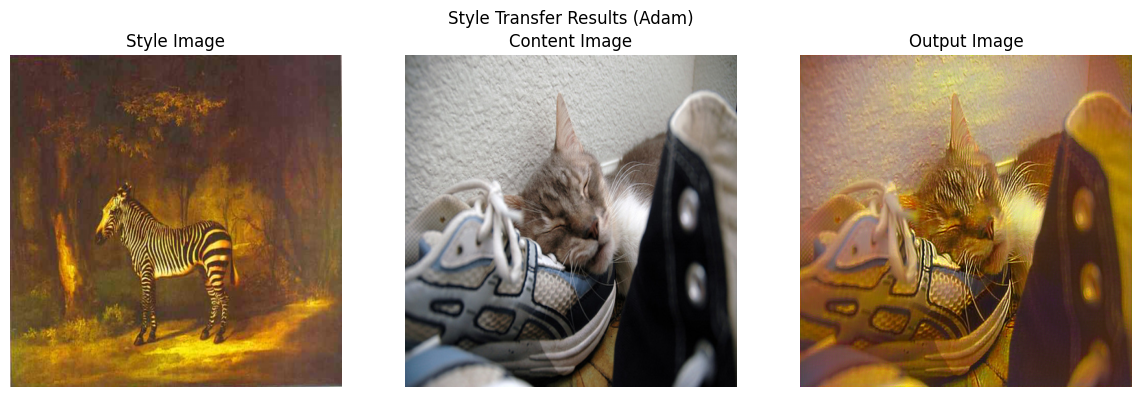

In [29]:
def style_transfer_adam(cnn, style_img, content_img, output_img, num_steps=1000, lr=0.005, style_weight=100000, content_weight=1, log=True):

    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)

    output_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = optim.Adam([output_img], lr=lr)

    step = [0]
    while step[0] <= num_steps:

        with torch.no_grad():
            output_img.clamp_(0, 1)

        optimizer.zero_grad()
        model(output_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()
        optimizer.step()

        step[0] += 1
        if log and step[0] % 50 == 0:
            print(f'Step {step[0]}: Style Loss={style_score.item():4f}, Content Loss={content_score.item():4f}')

    with torch.no_grad():
        output_img.clamp_(0, 1)

    return output_img.detach()

cnn = models.vgg19(weights='DEFAULT').features.eval()
output_img = style_transfer_adam(cnn, style_img, content_img, content_img.clone())
plot_style_transfer(style_img, content_img, output_img, "Style Transfer Results (Adam)")

### 2.4 Different Configurations of Weights

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


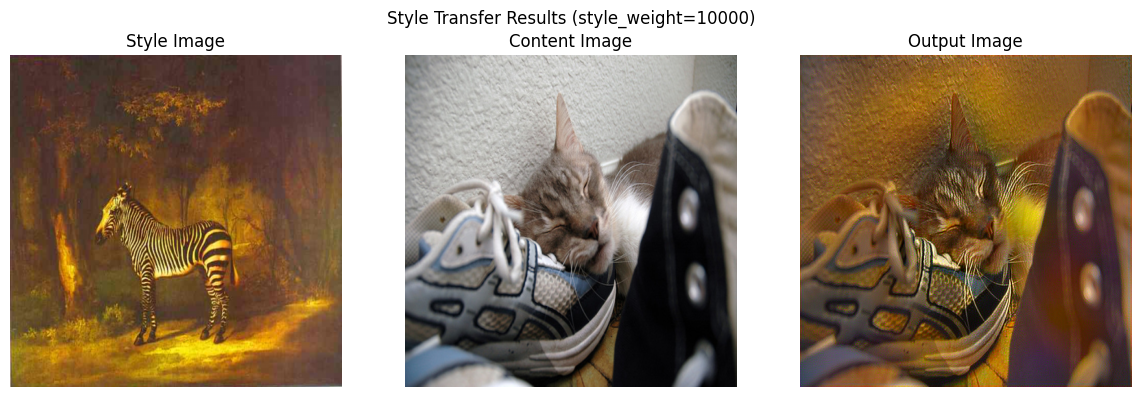

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


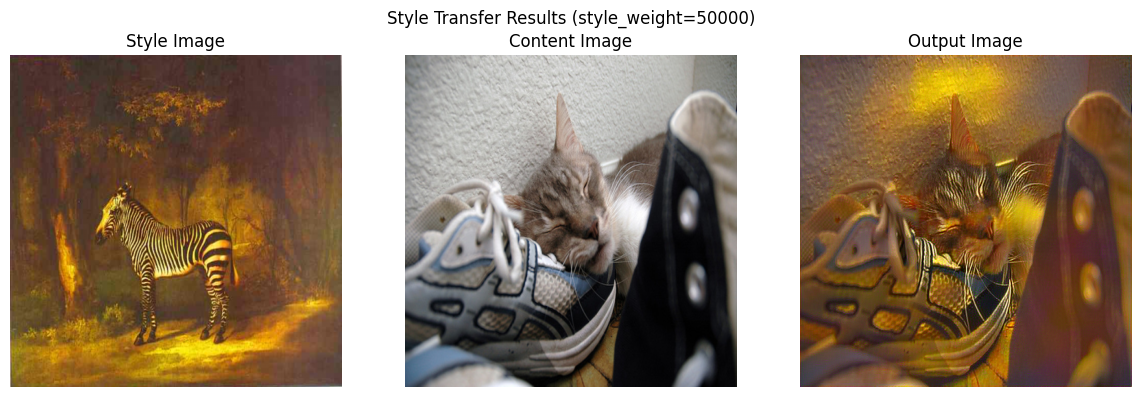

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


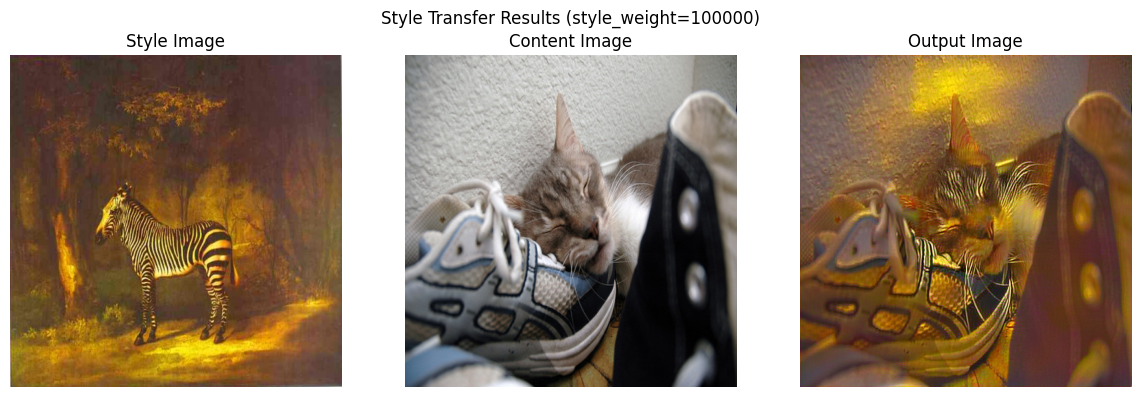

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


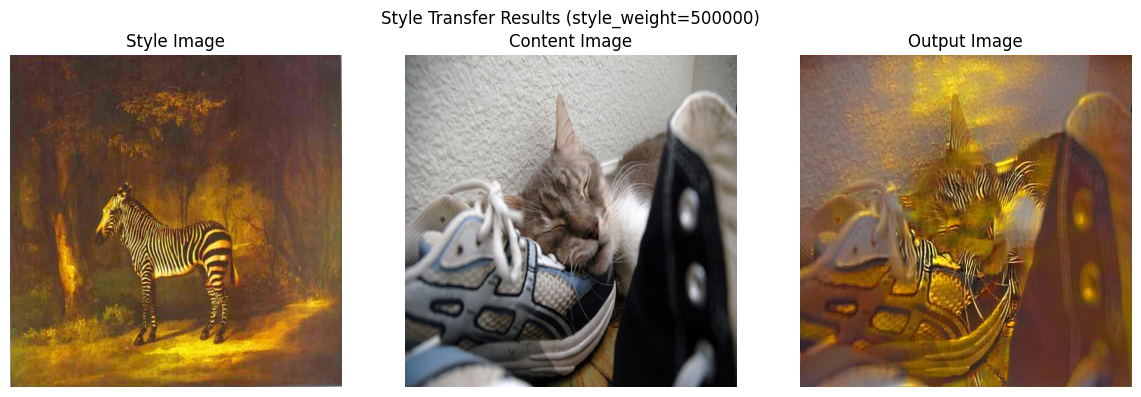

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


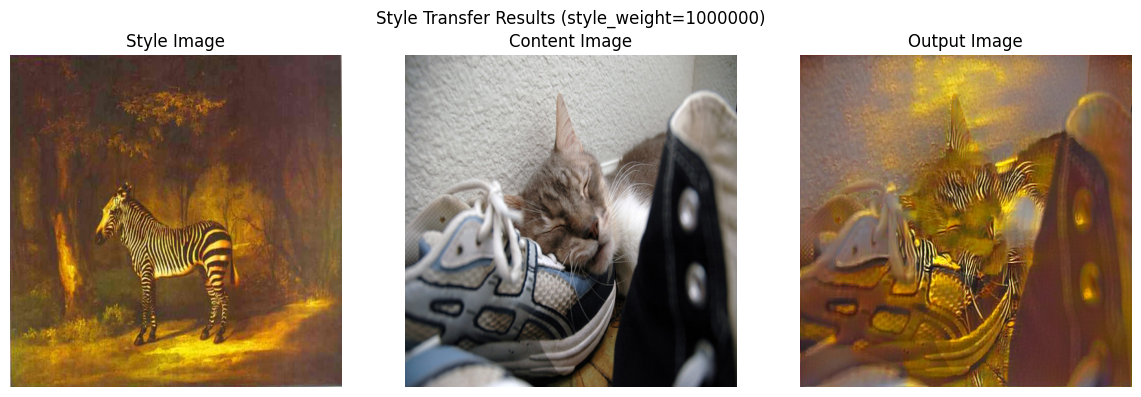

In [31]:
style_weights = [10000, 50000, 100000, 500000, 1000000]

for idx, style_weight in enumerate(style_weights):
    output_img = style_transfer_lbfgs(models.vgg19(weights='DEFAULT').features.eval(), style_img, content_img, content_img.clone(), style_weight=style_weight, log=False)
    plot_style_transfer(style_img, content_img, output_img, f"Style Transfer Results (style_weight={style_weight})")

### 2.5 Custom Photographs

**Note:** Outputs cleared due to concerns about online privacy.

In [51]:
# style_img = load_image("../data/q3/styles/the-exit-of-the-russian-ballet.jpg", transform=transform)
# content_img = load_image("/hdd/family/Maa/Disk 0/PHOTO/AA009.JPG", transform=transform)
# output_img = style_transfer_lbfgs(models.vgg19(weights='DEFAULT').features.eval(), style_img, content_img, content_img.clone())
# plot_style_transfer(style_img, content_img, output_img, "Style Transfer Results (Custom Image)", "custom_image_plot_1.png")
# cv2.imwrite("custom_image_1.png", (cv2.cvtColor(output_img.cpu().squeeze().permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR) * 255).astype(np.uint8))

In [50]:
# style_img = load_image("../data/q3/styles/the-exit-of-the-russian-ballet.jpg", transform=transform)
# content_img = load_image("/hdd/family/Maa/Disk 0/PHOTO/AA019.JPG", transform=transform)
# output_img = style_transfer_lbfgs(models.vgg19(weights='DEFAULT').features.eval(), style_img, content_img, content_img.clone())
# plot_style_transfer(style_img, content_img, output_img, "Style Transfer Results (Custom Image)", "custom_image_plot_2.png")
# cv2.imwrite("custom_image_2.png", (cv2.cvtColor(output_img.cpu().squeeze().permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR) * 255).astype(np.uint8))

### 2.6 Observations

- **Adam vs L-BFGS:** L-BFGS gives better results, yet converges faster.

- **Quality of Output:** This depends a lot on the choice of style content pair. If the initial style loss is too high (or the image pairs are incompatible), the content loss will be compromised to compensate for the high total loss.

- **Domain:** I couldn't find any evident relation with domain, but could do so with image complexity. We get much better, detail preserving output when the content image is less complex (e.g. zoomed in and focused on less number of entities). This could be attributed to our assumption of constant resolution.